In [15]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import geopandas as gpd
import pandas as pd
from typing import Callable, List, Tuple

from data.flood_event_1d2d_dataset import FloodEvent1D2DDataset
from utils import file_utils, plot_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dataset Visualization

In [16]:
config_path = 'configs/config_1d2d_model4.yaml'
config = file_utils.read_yaml_file(config_path)

In [17]:
mode = 'train' # 'train' or 'test'

dataset_parameters = config['dataset_parameters']
if mode == 'train':
    dataset_summary_file = dataset_parameters['training']['dataset_summary_file']
    event_stats_file = dataset_parameters['training']['event_stats_file']
else: # mode == 'test'
    dataset_summary_file = dataset_parameters['testing']['dataset_summary_file']
    event_stats_file = dataset_parameters['testing']['event_stats_file']

delta_t = dataset_parameters['timestep_interval']
previous_timesteps = dataset_parameters['previous_timesteps']
dataset = FloodEvent1D2DDataset(
    mode=mode,
    root_dir=dataset_parameters['root_dir'],
    dataset_summary_file=dataset_summary_file,
    nodes_2d_shp_file=dataset_parameters['nodes_2d_shp_file'],
    edges_2d_shp_file=dataset_parameters['edges_2d_shp_file'],
    nodes_1d_shp_file=dataset_parameters['nodes_1d_shp_file'],
    edges_1d_shp_file=dataset_parameters['edges_1d_shp_file'],
    edges_1d2d_shp_file=dataset_parameters['edges_1d2d_shp_file'],
    dem_file=dataset_parameters['dem_file'],
    event_stats_file=event_stats_file,
    features_stats_file=dataset_parameters['features_stats_file'],
    previous_timesteps=dataset_parameters['previous_timesteps'],
    normalize=dataset_parameters['normalize'],
    timestep_interval=delta_t,
    spin_up_time=dataset_parameters['spin_up_time'],
    time_from_peak=dataset_parameters['time_from_peak'],
    inflow_boundary_nodes=dataset_parameters['inflow_boundary_nodes'],
    outflow_boundary_nodes=dataset_parameters['outflow_boundary_nodes'],
    with_global_mass_loss=False,
    with_local_mass_loss=False,
    force_reload=True,
    save=False,
    perimeter_name=dataset_parameters['perimeter_name'],
    network_name=dataset_parameters['network_name']
)

HecRas Files: ['HEC-RAS_Results/Model_part3.p33.hdf', 'HEC-RAS_Results/Model.p24.hdf', 'HEC-RAS_Results/Model.p18.hdf', 'HEC-RAS_Results/Model_part2.p30.hdf', 'HEC-RAS_Results/Model.p32.hdf', 'HEC-RAS_Results/Model.p19.hdf', 'HEC-RAS_Results/Model_part3.p30.hdf', 'HEC-RAS_Results/Model_part3.p38.hdf', 'HEC-RAS_Results/Model_part3.p37.hdf', 'HEC-RAS_Results/Model.p25.hdf', 'HEC-RAS_Results/Model_part3.p23.hdf', 'HEC-RAS_Results/Model.p14.hdf', 'HEC-RAS_Results/Model_part2.p35.hdf', 'HEC-RAS_Results/Model_part3.p42.hdf', 'HEC-RAS_Results/Model_part3.p34.hdf', 'HEC-RAS_Results/Model_part3.p29.hdf', 'HEC-RAS_Results/Model_part3.p35.hdf', 'HEC-RAS_Results/Model_part3.p25.hdf', 'HEC-RAS_Results/Model_part3.p22.hdf', 'HEC-RAS_Results/Model_part3.p15.hdf', 'HEC-RAS_Results/Model.p16.hdf', 'HEC-RAS_Results/Model_part3.p27.hdf', 'HEC-RAS_Results/Model_part2.p17.hdf', 'HEC-RAS_Results/Model_part2.p34.hdf', 'HEC-RAS_Results/Model_part2.p22.hdf', 'HEC-RAS_Results/Model.p09.hdf', 'HEC-RAS_Results/Mo

In [18]:
print(f'Total number of events: {len(dataset.hec_ras_run_ids)}')
print(f'Total number of timesteps: {len(dataset)}')

Total number of events: 51
Total number of timesteps: 14337


In [19]:
if mode == 'train':
    start_ts = 0
    end_ts = None
else:  # mode == 'test'
    rollout_start = config['testing_parameters']['rollout_start']
    rollout_timesteps = config['testing_parameters']['rollout_timesteps']
    start_ts = rollout_start
    end_ts = (start_ts + rollout_timesteps) if rollout_timesteps is not None else None

delta_t_in_hours = delta_t / 3600
num_events = len(dataset.hec_ras_run_ids)
tick_interval_in_hours = 12

In [20]:
def plot_timeseries_per_event(
    dynamic_paths: List[str],
    data_key: str,
    feature_name: str,
    feature_idx: int,
    ylabel: str,
    title: str,
    aggregation_func: Callable = None,
    mask: np.ndarray = None,
):
    longest_hours_elapsed = []
    for run_id, path in zip(dataset.hec_ras_run_ids, dynamic_paths):
        data = np.load(path)[data_key][previous_timesteps:]
        feature_data = data[start_ts:end_ts, :, feature_idx]

        if mask is not None:
            # print(f'Applying mask: {mask}')
            feature_data = feature_data[:, mask]

        feature_data = dataset.normalizer.denormalize(feature_name, feature_data)

        if aggregation_func is not None:
            feature_data = aggregation_func(feature_data)

        # Plot
        hours_elapsed = np.arange(len(feature_data)) * delta_t_in_hours
        plt.plot(hours_elapsed, feature_data, label=f'Run {run_id}')

        if len(hours_elapsed) > len(longest_hours_elapsed):
            longest_hours_elapsed = hours_elapsed

    # Configure plot
    plt.title(title)
    plt.xlabel('Time (h)')
    interval_ticks = np.arange(0, len(longest_hours_elapsed), int(tick_interval_in_hours / delta_t_in_hours))
    plt.xticks(longest_hours_elapsed[interval_ticks])
    plt.ylabel(ylabel)
    plt.show()

# Plot 2D Node Features

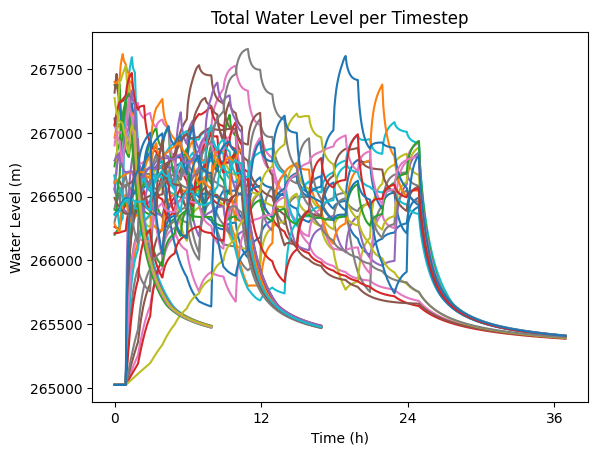

In [21]:
dynamic_nodes_paths = dataset.processed_paths[4:(num_events + 4)]
node_data_key = 'dynamic_nodes'
water_volume_idx = FloodEvent1D2DDataset.DYNAMIC_NODE_FEATURES.index('water_level')

plot_timeseries_per_event(
    dynamic_paths=dynamic_nodes_paths,
    data_key=node_data_key,
    feature_name='water_level',
    feature_idx=water_volume_idx,
    ylabel='Water Level (m)',
    title='Total Water Level per Timestep',
    aggregation_func=lambda x: x.sum(axis=1),
)

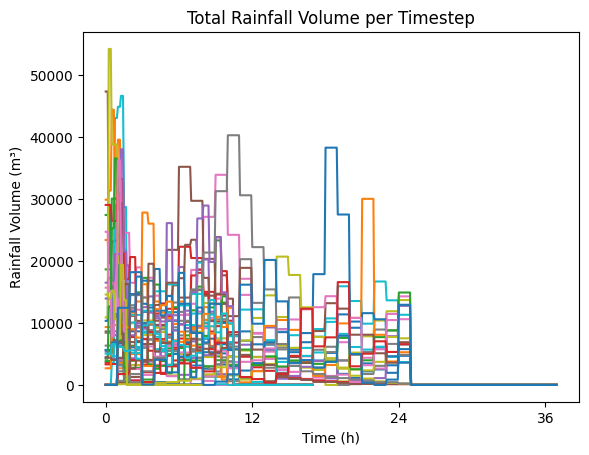

In [22]:
rainfall_idx = FloodEvent1D2DDataset.DYNAMIC_NODE_FEATURES.index('rainfall')

plot_timeseries_per_event(
    dynamic_paths=dynamic_nodes_paths,
    data_key=node_data_key,
    feature_name='rainfall',
    feature_idx=rainfall_idx,
    ylabel='Rainfall Volume (m³)',
    title='Total Rainfall Volume per Timestep',
    aggregation_func=lambda x: x.sum(axis=1),
)

# Plot 1D Dynamic Node Features

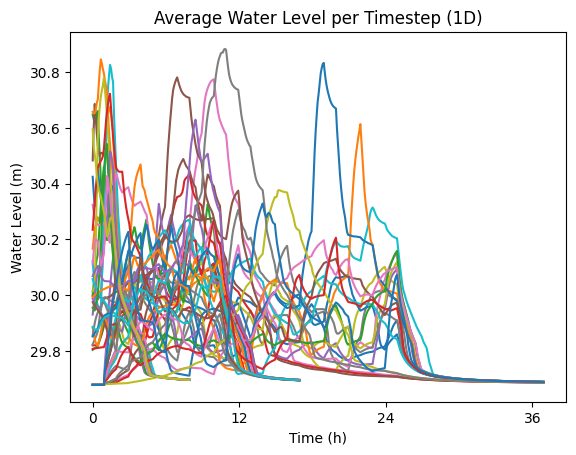

In [23]:
dynamic_nodes_1d_paths = dataset.processed_paths[4:(num_events + 4)]
node_1d_data_key = 'dynamic_nodes_1d'
water_level_idx = FloodEvent1D2DDataset.DYNAMIC_1D_NODE_FEATURES.index('water_level')

plot_timeseries_per_event(
    dynamic_paths=dynamic_nodes_1d_paths,
    data_key=node_1d_data_key,
    feature_name='water_level',
    feature_idx=water_level_idx,
    ylabel='Water Level (m)',
    title='Average Water Level per Timestep (1D)',
    aggregation_func=lambda x: x.mean(axis=1),
)

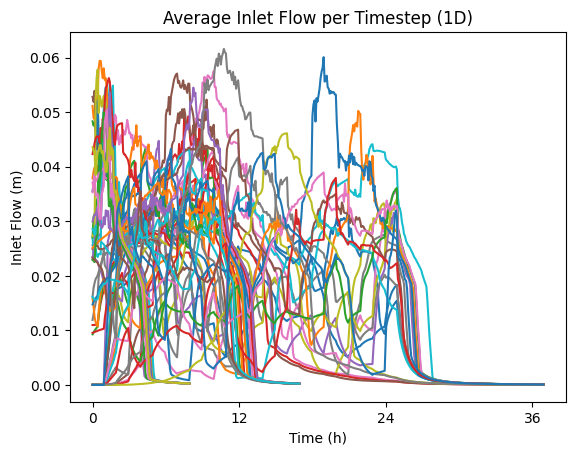

In [24]:
dynamic_nodes_1d_paths = dataset.processed_paths[4:(num_events + 4)]
node_1d_data_key = 'dynamic_nodes_1d'
water_level_idx = FloodEvent1D2DDataset.DYNAMIC_1D_NODE_FEATURES.index('inlet_flow')

plot_timeseries_per_event(
    dynamic_paths=dynamic_nodes_1d_paths,
    data_key=node_1d_data_key,
    feature_name='inlet_flow',
    feature_idx=water_level_idx,
    ylabel='Inlet Flow (m)',
    title='Average Inlet Flow per Timestep (1D)',
    aggregation_func=lambda x: x.mean(axis=1),
)

# Plot 2D Dynamic Edge Features

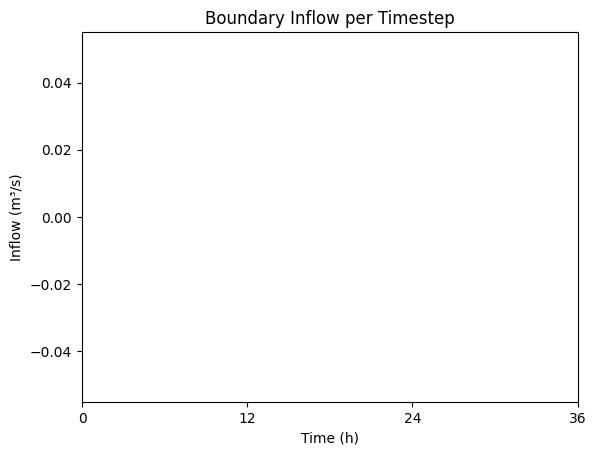

In [25]:
# Plot total inflow per timestep
dynamic_edges_paths = dataset.processed_paths[4:(num_events + 4)]
edge_data_key = 'dynamic_edges'
flow_idx = FloodEvent1D2DDataset.DYNAMIC_EDGE_FEATURES.index('flow')
inflow_edge_mask = dataset.boundary_condition.inflow_edges_mask

plot_timeseries_per_event(
    dynamic_paths=dynamic_edges_paths,
    data_key=edge_data_key,
    feature_name='flow',
    feature_idx=flow_idx,
    ylabel='Inflow (m³/s)',
    title='Boundary Inflow per Timestep',
    mask=inflow_edge_mask,
)

In [26]:
event_end_idx = [*dataset.event_start_idx, dataset.total_rollout_timesteps]
event_size = np.diff(event_end_idx)

for i, run_id in enumerate(dataset.hec_ras_run_ids):
    print(f'Run {run_id} - Event Size: {event_size[i]} timesteps')

Run 56 - Event Size: 443 timesteps
Run 34 - Event Size: 95 timesteps
Run 3 - Event Size: 95 timesteps
Run 55 - Event Size: 203 timesteps
Run 80 - Event Size: 95 timesteps
Run 23 - Event Size: 95 timesteps
Run 14 - Event Size: 443 timesteps
Run 6 - Event Size: 443 timesteps
Run 78 - Event Size: 443 timesteps
Run 85 - Event Size: 95 timesteps
Run 2 - Event Size: 443 timesteps
Run 12 - Event Size: 95 timesteps
Run 38 - Event Size: 203 timesteps
Run 45 - Event Size: 443 timesteps
Run 16 - Event Size: 443 timesteps
Run 1 - Event Size: 443 timesteps
Run 43 - Event Size: 443 timesteps
Run 40 - Event Size: 443 timesteps
Run 9 - Event Size: 443 timesteps
Run 58 - Event Size: 443 timesteps
Run 75 - Event Size: 95 timesteps
Run 15 - Event Size: 443 timesteps
Run 72 - Event Size: 203 timesteps
Run 57 - Event Size: 203 timesteps
Run 83 - Event Size: 203 timesteps
Run 13 - Event Size: 203 timesteps
Run 46 - Event Size: 203 timesteps
Run 20 - Event Size: 203 timesteps
Run 25 - Event Size: 95 timestep

Nodes with the highest water volume difference:
Node 3709: 82.42 m
Node 3708: 82.18 m
Node 3528: 42.17 m
Node 8706: 32.12 m
Node 4250: 28.70 m
Init inflow boundary nodes:  None
Init outflow boundary nodes:  [8940, 8964, 8965, 8967, 8968, 8969, 8970, 8972, 8973, 8974, 8975, 8977, 8982, 8986, 8991, 8998, 9003, 9005, 9006, 9007, 9008, 9009, 9010, 9011, 9012, 9014, 9018, 9021, 9022, 9025, 9026, 9029, 9030, 9034, 9038, 9040, 9041, 9044, 9048, 9050, 9051, 9052, 9053, 9055, 9057, 9059, 9060, 9061, 9063, 9065, 9067, 9068, 9069, 9071, 9074, 9078, 9087, 9090, 9093, 9094, 9095, 9097, 9100, 9101, 9107, 9110, 9118, 9124, 9128, 9131, 9137, 9140, 9144, 9150, 9154, 9158, 9167, 9171, 9172, 9173, 9174, 9175, 9176, 9177, 9178, 9179, 9180, 9181, 9182, 9183, 9186, 9187, 9188, 9189, 9190, 9191, 9192, 9193, 9194, 9195, 9198, 9199, 9212, 9219]


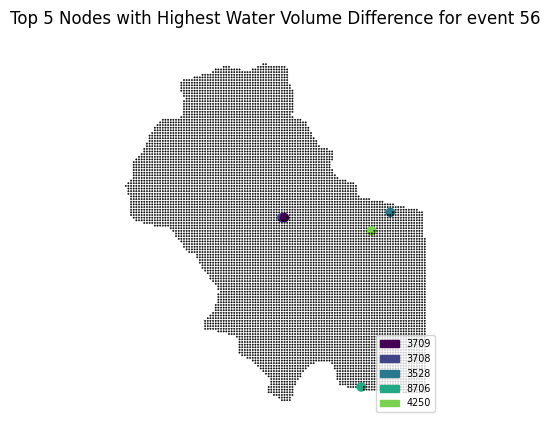

In [27]:
def get_highest_diff_entities(dynamic_path: str,
                              data_key: str,
                              feature_name: str,
                              feature_idx: int,
                              k: int = 4) -> Tuple[List, np.ndarray]:
    data = np.load(dynamic_path)[data_key]
    feature_data = data[:, :, feature_idx]
    feature_data = dataset.normalizer.denormalize(feature_name, feature_data)
    feature_diff = np.abs(np.diff(feature_data, axis=0))
    feature_diff_per_entity = feature_diff.sum(axis=0)

    top_k_diff_idx = np.argsort(feature_diff_per_entity)[-k:][::-1].tolist()
    top_k_wd_diff = feature_diff_per_entity[top_k_diff_idx]
    return top_k_diff_idx, top_k_wd_diff


EVENT_IDX = 0  # Change this to the desired event index
k = 5  # Number of top nodes to retrieve

event_dynamic_nodes_path = dynamic_nodes_paths[EVENT_IDX]
top_k_wv_diff_idx, top_k_wv_diff = get_highest_diff_entities(dynamic_path=event_dynamic_nodes_path,
                                                             data_key=node_data_key,
                                                             feature_name='water_volume',
                                                             feature_idx=water_volume_idx,
                                                             k=k)
print('Nodes with the highest water volume difference:')
for idx, wv in zip(top_k_wv_diff_idx, top_k_wv_diff):
    print(f"Node {idx}: {wv:.2f} m")

run_id = dataset.hec_ras_run_ids[EVENT_IDX]
node_df = plot_utils.get_node_df(config, run_id, mode=mode, no_ghost=True, perimeter_name=dataset_parameters['perimeter_name'],)
plot_utils.plot_cell_map_w_highlight(gpdf=node_df,
                                     title=f'Top {k} Nodes with Highest Water Volume Difference for event {run_id}',
                                     highlight_idxs=top_k_wv_diff_idx)

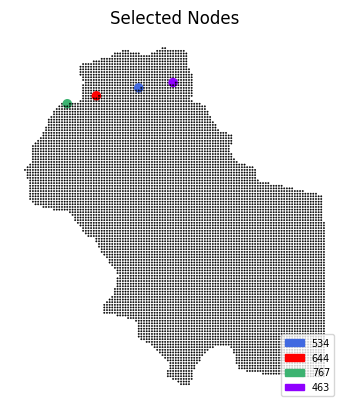

In [28]:
highlight_node_idx = [534, 644, 767, 463]
color_list = ['#4169E1', '#FF0000', '#3CB371', '#8F00FF']
plot_utils.plot_cell_map_w_highlight(node_df,
                                    title='Selected Nodes',
                                    highlight_idxs=highlight_node_idx,
                                    color_list=color_list,
                                    legend=False)

Edges with the highest water flow difference:
Edge 8876: 204.39 m
Edge 9061: 177.08 m
Edge 9239: 97.36 m
Edge 8286: 67.04 m
Edge 8075: 65.97 m
Init inflow boundary nodes:  None
Init outflow boundary nodes:  [8940, 8964, 8965, 8967, 8968, 8969, 8970, 8972, 8973, 8974, 8975, 8977, 8982, 8986, 8991, 8998, 9003, 9005, 9006, 9007, 9008, 9009, 9010, 9011, 9012, 9014, 9018, 9021, 9022, 9025, 9026, 9029, 9030, 9034, 9038, 9040, 9041, 9044, 9048, 9050, 9051, 9052, 9053, 9055, 9057, 9059, 9060, 9061, 9063, 9065, 9067, 9068, 9069, 9071, 9074, 9078, 9087, 9090, 9093, 9094, 9095, 9097, 9100, 9101, 9107, 9110, 9118, 9124, 9128, 9131, 9137, 9140, 9144, 9150, 9154, 9158, 9167, 9171, 9172, 9173, 9174, 9175, 9176, 9177, 9178, 9179, 9180, 9181, 9182, 9183, 9186, 9187, 9188, 9189, 9190, 9191, 9192, 9193, 9194, 9195, 9198, 9199, 9212, 9219]


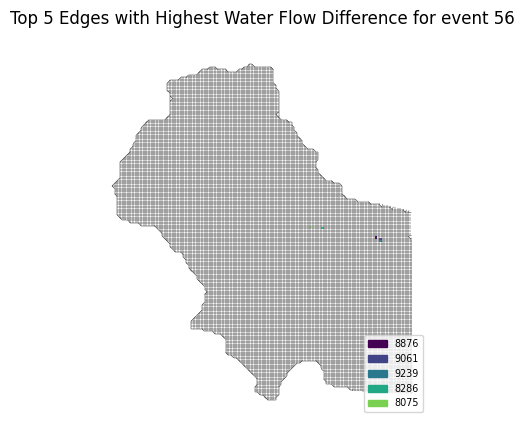

In [29]:
def get_highest_diff_water_flow_edges(dataset: FloodEvent1D2DDataset, event_idx: int, k: int = 4) -> tuple[list, np.ndarray]:
    num_events = len(dataset.hec_ras_run_ids)
    dynamic_edges_paths = dataset.processed_paths[4:(num_events + 4)]

    dynamic_edges = np.load(dynamic_edges_paths[event_idx])['dynamic_edges']
    water_flow_idx = FloodEvent1D2DDataset.DYNAMIC_EDGE_FEATURES.index(FloodEvent1D2DDataset.EDGE_TARGET_FEATURE)
    water_flow = dynamic_edges[:, :, water_flow_idx]
    water_flow = dataset.normalizer.denormalize(FloodEvent1D2DDataset.EDGE_TARGET_FEATURE, water_flow)
    wf_diff = np.abs(np.diff(water_flow, axis=0))
    wf_diff_per_edge = wf_diff.sum(axis=0)

    top_k_diff_idx = np.argsort(wf_diff_per_edge)[-k:][::-1].tolist()
    top_k_wf_diff = wf_diff_per_edge[top_k_diff_idx]
    return top_k_diff_idx, top_k_wf_diff

# def get_edge_df(dataset: FloodEventDataset, no_ghost: bool = True) -> gpd.GeoDataFrame:
#     edges_shp_path = dataset.raw_paths[1]
#     link_df = gpd.read_file(edges_shp_path)

#     if no_ghost:
#         bc = dataset.boundary_condition
#         inflow_boundary_nodes = dataset.inflow_boundary_nodes
#         outflow_boundary_nodes = dataset.outflow_boundary_nodes
#         is_ghost_edge = link_df['from_node'].isin(bc.ghost_nodes) | link_df['to_node'].isin(bc.ghost_nodes)
#         boundary_nodes = np.concat([np.array(dataset.inflow_boundary_nodes), np.array(dataset.outflow_boundary_nodes)])
#         is_boundary_edge = link_df['from_node'].isin(boundary_nodes) | link_df['to_node'].isin(boundary_nodes)
#         link_df = pd.concat([link_df[~is_ghost_edge], link_df[is_ghost_edge & is_boundary_edge]], ignore_index=True)

#         assert np.all(link_df['from_node'][bc.inflow_edges_mask].isin(inflow_boundary_nodes) | link_df['to_node'][bc.inflow_edges_mask].isin(inflow_boundary_nodes)), "Inflow of link DataFrame does not match the inflow edges mask"
#         assert np.all(link_df['from_node'][bc.outflow_edges_mask].isin(outflow_boundary_nodes) | link_df['to_node'][bc.outflow_edges_mask].isin(outflow_boundary_nodes)), "Outflow of link DataFrame does not match the outflow edges mask"

#     return link_df

EVENT_IDX = 0  # Change this to the desired event index
k = 5  # Number of top edges to retrieve

event_dynamic_edges_path = dynamic_edges_paths[EVENT_IDX]
top_k_wf_diff_idx, top_k_wf_diff = get_highest_diff_entities(dynamic_path=event_dynamic_edges_path,
                                                             data_key=edge_data_key,
                                                             feature_name='flow',
                                                             feature_idx=flow_idx,
                                                             k=k)
print('Edges with the highest water flow difference:')
for idx, wf in zip(top_k_wf_diff_idx, top_k_wf_diff):
    print(f"Edge {idx}: {wf:.2f} m")

run_id = dataset.hec_ras_run_ids[EVENT_IDX]
edge_df = plot_utils.get_edge_df(config, run_id, mode=mode, no_ghost=True, perimeter_name=dataset_parameters['perimeter_name'],)
plot_utils.plot_cell_map_w_highlight(gpdf=edge_df,
                                     title=f'Top {k} Edges with Highest Water Flow Difference for event {run_id}',
                                     highlight_idxs=top_k_wf_diff_idx)

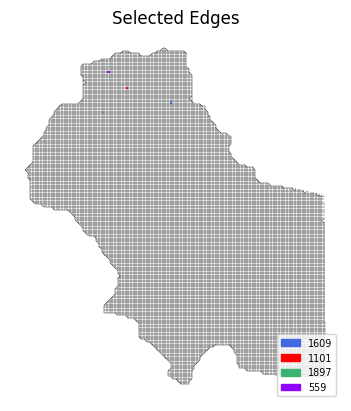

In [30]:
highlight_edge_idx = [1609, 1101, 1897, 559]
color_list = ['#4169E1', '#FF0000', '#3CB371', '#8F00FF']
plot_utils.plot_cell_map_w_highlight(edge_df,
                                     title='Selected Edges',
                                     highlight_idxs=highlight_edge_idx,
                                     color_list=color_list,
                                     legend=True)

In [31]:
feature_stats_path = dataset.processed_paths[1]
feature_stats = file_utils.read_yaml_file(feature_stats_path)
print("Feature statistics:")
for feature_name, stats in feature_stats.items():
    print(f"{feature_name}")
    print(f"\tMean: {stats['mean']:.4f}")
    print(f"\tStd: {stats['std']:.4f}")
    print(f"\tMin: {stats['min']:.4f}")
    print(f"\tMax: {stats['max']:.4f}")

Feature statistics:
area
	Mean: 400.0132
	Std: 52.4408
	Min: 0.0000
	Max: 893.4809
aspect
	Mean: 156.8376
	Std: 98.1976
	Min: -1.0000
	Max: 359.9951
base_area
	Mean: 1.8761
	Std: 2.9167
	Min: 0.0000
	Max: 21.8881
curvature
	Mean: 0.0091
	Std: 0.0870
	Min: 0.0000
	Max: 5.1849
depth
	Mean: 2.0086
	Std: 2.3984
	Min: -9.9200
	Max: 29.9400
diameter
	Mean: 0.6857
	Std: 0.4140
	Min: 0.2250
	Max: 2.5000
elevation
	Mean: 33.2271
	Std: 25.1340
	Min: -0.4844
	Max: 83.7812
face_length
	Mean: 19.9017
	Std: 1.8303
	Min: 0.0000
	Max: 40.0000
flow
	Mean: 0.2280
	Std: 0.7362
	Min: -0.4512
	Max: 10.5289
flow_accumulation
	Mean: 1.6582
	Std: 1.5860
	Min: 1.0000
	Max: 30.0000
inlet_flow
	Mean: 0.0156
	Std: 0.1231
	Min: -3.6889
	Max: 2.3287
invert_elevation
	Mean: 30.4080
	Std: 20.0473
	Min: 1.1000
	Max: 78.8300
length
	Mean: 59.3817
	Std: 31.9764
	Min: 11.4018
	Max: 216.1227
min_elevation
	Mean: nan
	Std: nan
	Min: nan
	Max: nan
position_x
	Mean: 338404.5000
	Std: 430.7525
	Min: 337562.0000
	Max: 339171.2

# Plot 2D Static Node & Edge Features

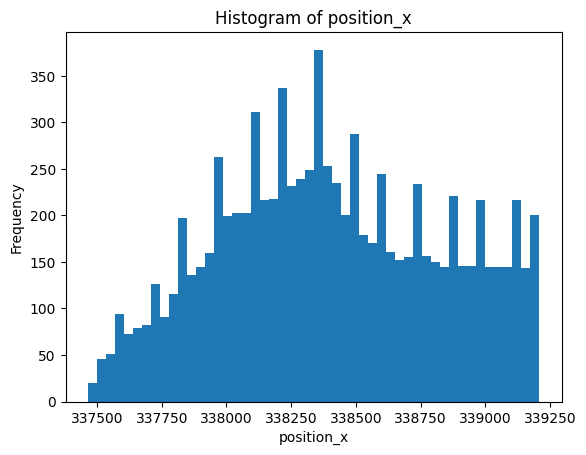

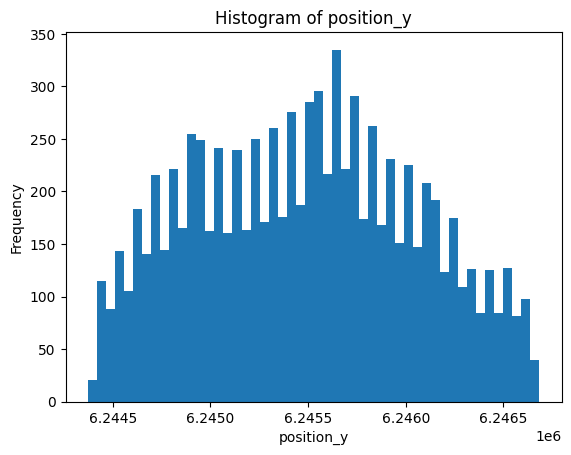

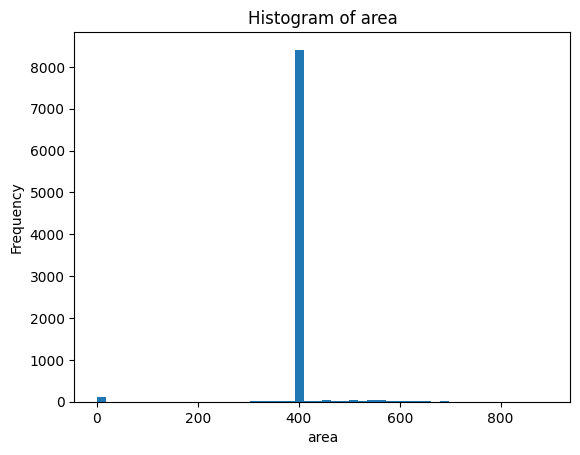

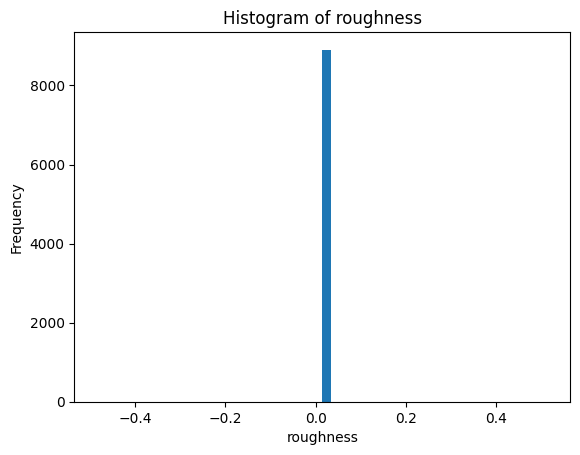

/opt/anaconda3/envs/flood_gnn/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7104: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/opt/anaconda3/envs/flood_gnn/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7105: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

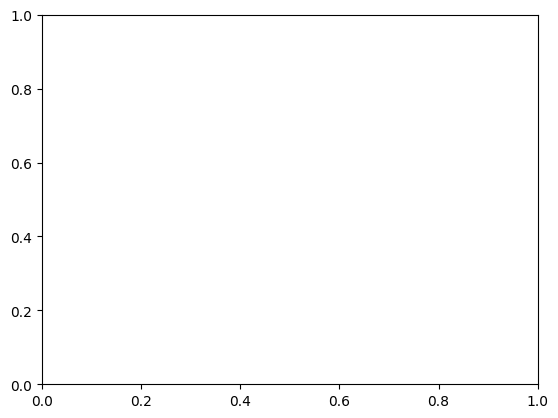

In [32]:
constant_values_path = dataset.processed_paths[3]
bins = 50

static_features = FloodEvent1D2DDataset.STATIC_NODE_FEATURES + FloodEvent1D2DDataset.STATIC_EDGE_FEATURES
feature_idxs = [*(range(dataset.num_static_node_features)), *(range(dataset.num_static_edge_features))]
keys = [*(['static_nodes'] * dataset.num_static_node_features), *(['static_edges'] * dataset.num_static_edge_features)]
for feature, index, key in zip(static_features, feature_idxs, keys):
    data = np.load(constant_values_path)[key]
    feature_data = data[:, index]
    if dataset.is_normalized:
        feature_data = dataset.normalizer.denormalize(feature, feature_data)
    plt.hist(feature_data, bins=bins)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Plot 2D Dynamic Node & Edge Features

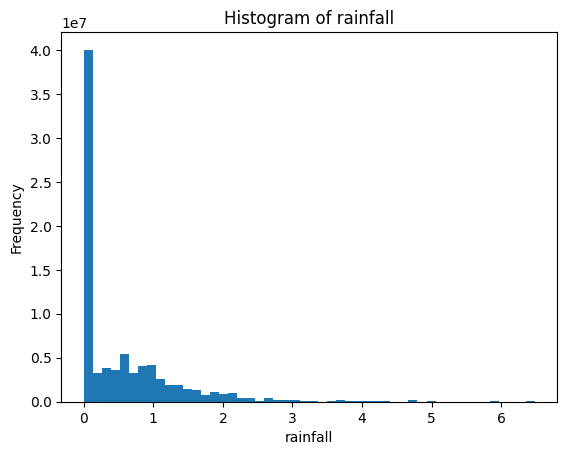

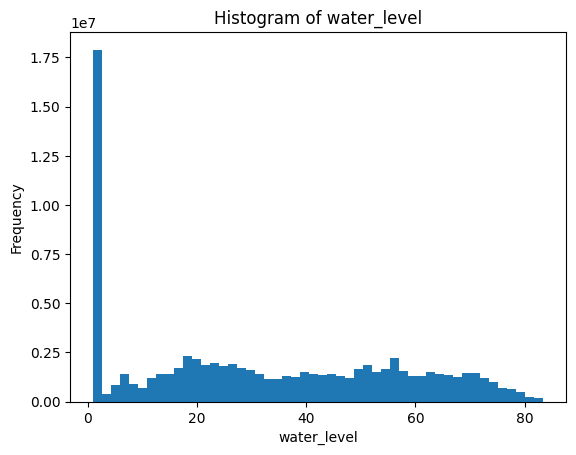

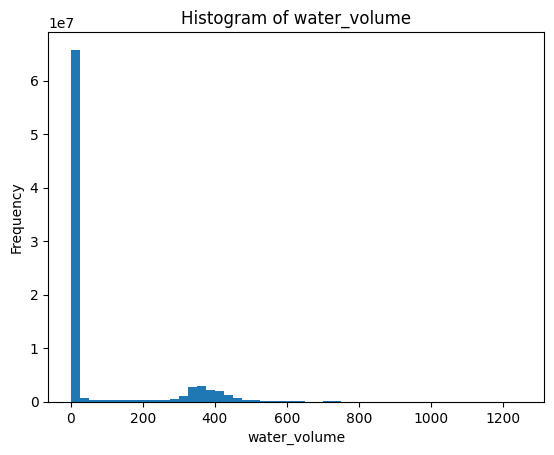

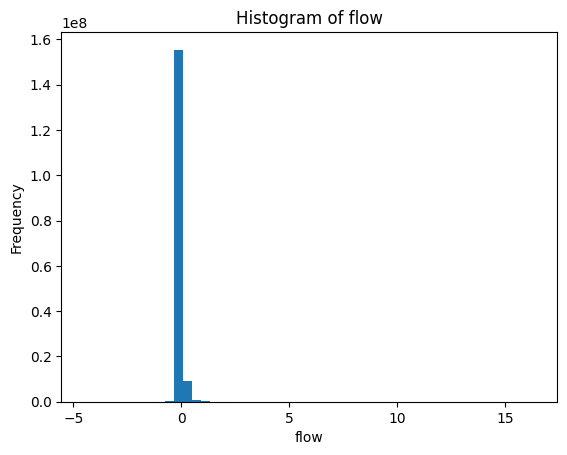

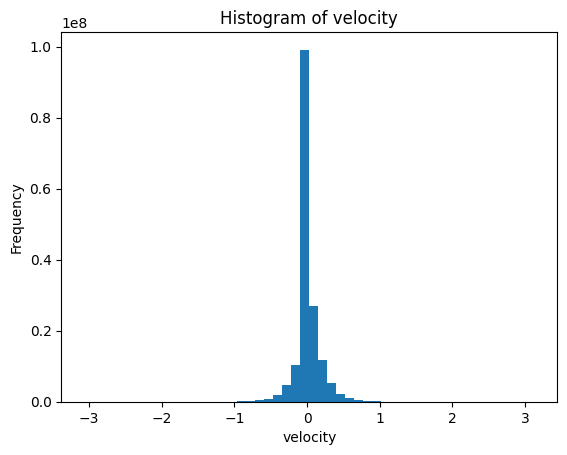

In [ ]:
num_events = len(dataset.hec_ras_run_ids)
dynamic_values_paths = dataset.processed_paths[4:(num_events + 4)]

dynamic_features = FloodEvent1D2DDataset.DYNAMIC_NODE_FEATURES + FloodEvent1D2DDataset.DYNAMIC_EDGE_FEATURES
feature_idxs = [*(range(dataset.num_dynamic_node_features)), *(range(dataset.num_dynamic_edge_features))]
keys = [*(['dynamic_nodes'] * dataset.num_dynamic_node_features), *(['dynamic_edges'] * dataset.num_dynamic_edge_features)]
for feature, index, key in zip(dynamic_features, feature_idxs, keys):
    all_feature_data = []
    for path in dynamic_values_paths:
        data = np.load(path)[key]
        feature_data = data[:, :, index]
        if dataset.is_normalized:
            feature_data = dataset.normalizer.denormalize(feature, feature_data)
        all_feature_data.append(feature_data.flatten())
    all_feature_data = np.concatenate(all_feature_data)
    plt.hist(all_feature_data, bins=bins)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


# Plot 1D Static Node & Edge Features

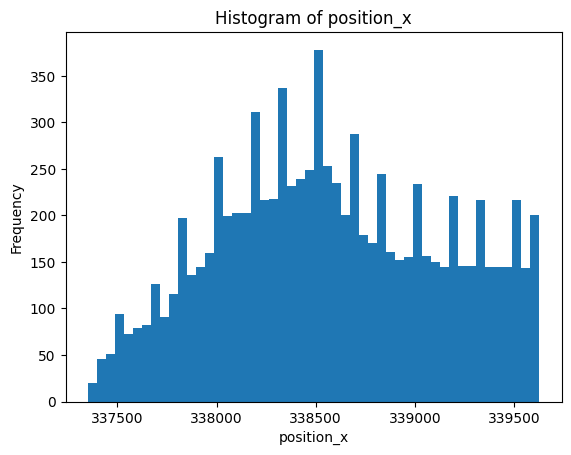

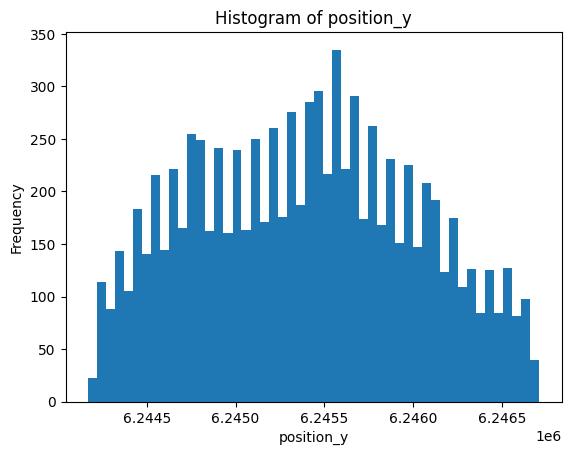

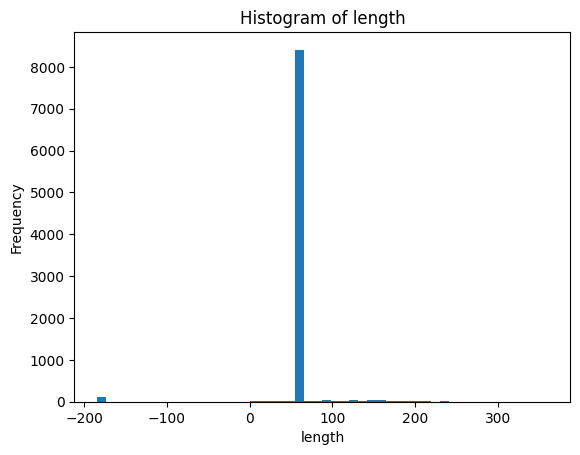

In [ ]:
constant_values_path = dataset.processed_paths[3]
bins = 50

static_features = FloodEvent1D2DDataset.STATIC_1D_NODE_FEATURES + FloodEvent1D2DDataset.STATIC_1D_EDGE_FEATURES
feature_idxs = [*(range(dataset.num_static_node_features)), *(range(dataset.num_static_edge_features))]
keys = [*(['static_nodes'] * dataset.num_static_node_features), *(['static_edges'] * dataset.num_static_edge_features)]
for feature, index, key in zip(static_features, feature_idxs, keys):
    data = np.load(constant_values_path)[key]
    feature_data = data[:, index]
    if dataset.is_normalized:
        feature_data = dataset.normalizer.denormalize(feature, feature_data)
    plt.hist(feature_data, bins=bins)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Plot 1D Dynamic Node & Edge Features

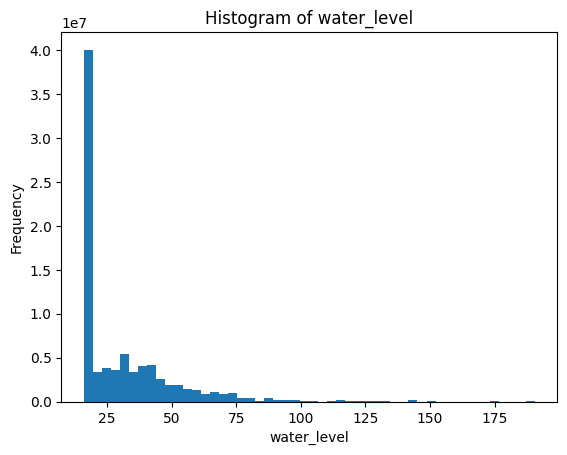

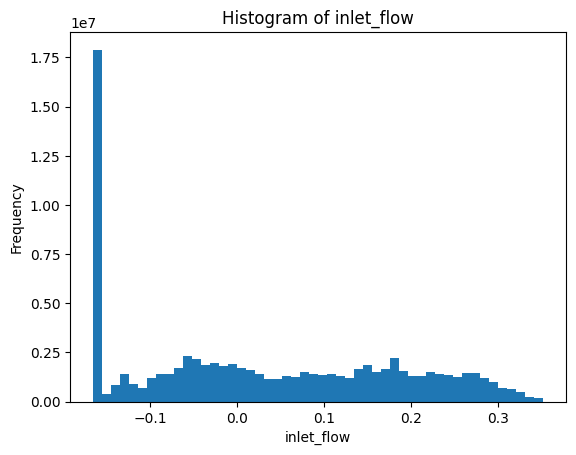

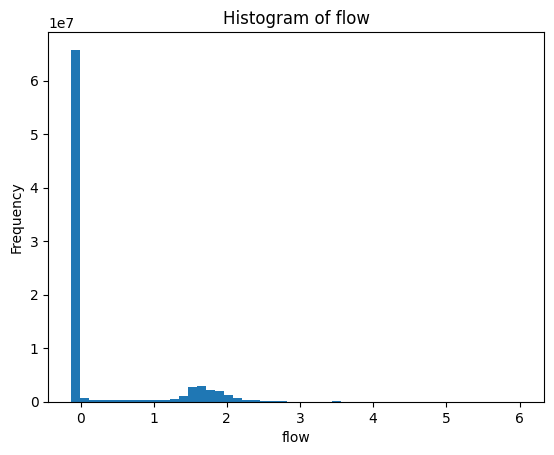

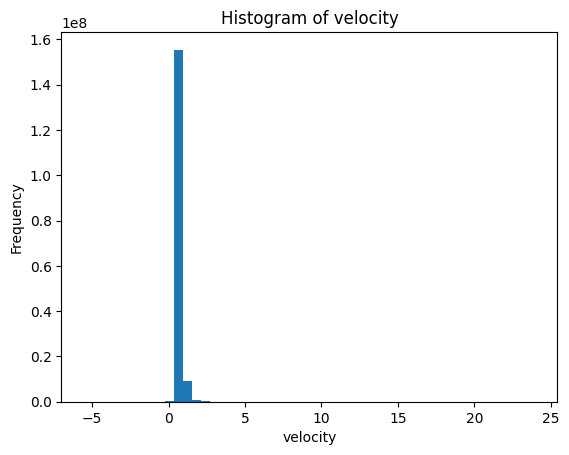

In [ ]:
num_events = len(dataset.hec_ras_run_ids)
dynamic_values_paths = dataset.processed_paths[4:(num_events + 4)]

dynamic_features = FloodEvent1D2DDataset.DYNAMIC_1D_NODE_FEATURES + FloodEvent1D2DDataset.DYNAMIC_1D_EDGE_FEATURES
feature_idxs = [*(range(dataset.num_dynamic_node_features)), *(range(dataset.num_dynamic_edge_features))]
keys = [*(['dynamic_nodes'] * dataset.num_dynamic_node_features), *(['dynamic_edges'] * dataset.num_dynamic_edge_features)]
for feature, index, key in zip(dynamic_features, feature_idxs, keys):
    all_feature_data = []
    for path in dynamic_values_paths:
        data = np.load(path)[key]
        feature_data = data[:, :, index]
        if dataset.is_normalized:
            feature_data = dataset.normalizer.denormalize(feature, feature_data)
        all_feature_data.append(feature_data.flatten())
    all_feature_data = np.concatenate(all_feature_data)
    plt.hist(all_feature_data, bins=bins)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


In [ ]:
from typing import Optional, Union


def plot_nodes_from_csv(
    data_csv_path: str,
    timestamp_csv_path: str,
    feature_column: str,
    ylabel: str,
    title: str,
    selected_nodes: Optional[Union[List[int], int]] = None,
    num_random_nodes: int = 10,
    random_seed: Optional[int] = None,
    node_alpha: float = 0.8,
    show_node_ids: bool = True,
    colormap: str = 'tab10',
    timestep_column: str = 'timestep',
    node_column: str = 'node_idx',
    timestamp_idx_column: str = 'timestep_idx',
    timestamp_column: str = 'timestamp',
    date_format: Optional[str] = None,
    time_unit: str = 'auto',  # 'auto', 'hours', 'minutes', 'datetime'
    figsize: tuple = (12, 6),
):
    """
    Plot timeseries for multiple nodes from CSV files.
    
    Reads node data from one CSV and timestamp mapping from another CSV,
    then plots the timeseries of selected nodes.
    
    Args:
        data_csv_path: Path to CSV file containing node data
        timestamp_csv_path: Path to CSV file containing timestep-to-timestamp mapping
        feature_column: Column name of the feature to plot (e.g., 'water_level', 'rainfall')
        ylabel: Label for y-axis
        title: Plot title
        selected_nodes: Specific node indices to plot. Can be:
                       - List of integers: specific node indices
                       - Integer: single node index
                       - None: randomly select nodes
        num_random_nodes: Number of random nodes to select if selected_nodes is None
        random_seed: Seed for random node selection
        node_alpha: Transparency for node lines (0-1)
        show_node_ids: If True, shows node IDs in legend
        colormap: Matplotlib colormap name for node colors
        timestep_column: Column name for timestep in data CSV (default: 'timestep')
        node_column: Column name for node index in data CSV (default: 'node_idx')
        timestamp_idx_column: Column name for timestep index in timestamp CSV (default: 'timestep_idx')
        timestamp_column: Column name for timestamp in timestamp CSV (default: 'timestamp')
        date_format: Format string for parsing timestamps (e.g., '%Y-%m-%d %H:%M:%S')
                    If None, pandas will infer the format
        time_unit: How to display time on x-axis:
                  - 'auto': automatically choose based on data range
                  - 'hours': hours since start
                  - 'minutes': minutes since start
                  - 'datetime': actual datetime values
        figsize: Figure size (width, height)
    
    Returns:
        dict: Contains node_indices, feature statistics, and dataframe
    
    Example:
        >>> # Plot 10 random nodes with water level
        >>> result = plot_nodes_from_csv(
        ...     data_csv_path="simulation_output.csv",
        ...     timestamp_csv_path="timestamps.csv",
        ...     feature_column="water_level",
        ...     ylabel="Water Level (m)",
        ...     title="Water Level at 10 Random Nodes",
        ...     num_random_nodes=10,
        ...     random_seed=42
        ... )
        
        >>> # Plot specific nodes with rainfall
        >>> plot_nodes_from_csv(
        ...     data_csv_path="simulation_output.csv",
        ...     timestamp_csv_path="timestamps.csv",
        ...     feature_column="rainfall",
        ...     ylabel="Rainfall (mm)",
        ...     title="Rainfall at Monitoring Points",
        ...     selected_nodes=[0, 5, 10, 15, 20],
        ...     time_unit='datetime'
        ... )
    """
    
    print("=" * 80)
    print("LOADING DATA FROM CSV FILES")
    print("=" * 80)
    
    # Load data CSV
    print(f"\nLoading data from: {data_csv_path}")
    data_df = pd.read_csv(data_csv_path)
    print(f"  Rows: {len(data_df):,}")
    print(f"  Columns: {list(data_df.columns)}")
    
    # Validate required columns in data CSV
    required_data_cols = [timestep_column, node_column, feature_column]
    missing_cols = [col for col in required_data_cols if col not in data_df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in data CSV: {missing_cols}")
    
    # Load timestamp CSV
    print(f"\nLoading timestamps from: {timestamp_csv_path}")
    timestamp_df = pd.read_csv(timestamp_csv_path)
    print(f"  Rows: {len(timestamp_df):,}")
    print(f"  Columns: {list(timestamp_df.columns)}")
    
    # Validate required columns in timestamp CSV
    required_ts_cols = [timestamp_idx_column, timestamp_column]
    missing_cols = [col for col in required_ts_cols if col not in timestamp_df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in timestamp CSV: {missing_cols}")
    
    # Parse timestamps
    if date_format:
        timestamp_df[timestamp_column] = pd.to_datetime(
            timestamp_df[timestamp_column], 
            format=date_format
        )
    else:
        timestamp_df[timestamp_column] = pd.to_datetime(timestamp_df[timestamp_column])
    
    print(f"  Timestamp range: {timestamp_df[timestamp_column].min()} to {timestamp_df[timestamp_column].max()}")
    
    # Get unique nodes and timesteps
    unique_nodes = sorted(data_df[node_column].unique())
    unique_timesteps = sorted(data_df[timestep_column].unique())
    
    print(f"\nData Summary:")
    print(f"  Unique nodes: {len(unique_nodes)}")
    print(f"  Unique timesteps: {len(unique_timesteps)}")
    print(f"  Feature '{feature_column}' range: [{data_df[feature_column].min():.4f}, {data_df[feature_column].max():.4f}]")
    
    # Set random seed if provided
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Determine which nodes to plot
    if selected_nodes is None:
        # Randomly select nodes
        node_indices = np.random.choice(
            unique_nodes, 
            size=min(num_random_nodes, len(unique_nodes)), 
            replace=False
        )
        node_indices = np.sort(node_indices)
    elif isinstance(selected_nodes, int):
        # Single node
        node_indices = np.array([selected_nodes])
    else:
        # List of specific nodes
        node_indices = np.array(selected_nodes)
        # Filter out nodes not in data
        valid_mask = np.isin(node_indices, unique_nodes)
        if not np.all(valid_mask):
            invalid_nodes = node_indices[~valid_mask]
            print(f"\nWarning: Removed nodes not in data: {invalid_nodes}")
        node_indices = node_indices[valid_mask]
    
    print(f"\nPlotting {len(node_indices)} nodes: {node_indices}")
    
    # Create time axis based on time_unit setting
    start_time = timestamp_df[timestamp_column].iloc[0]
    
    if time_unit == 'datetime' or time_unit == 'auto':
        # Use actual datetime values
        time_values = timestamp_df[timestamp_column].values
        use_datetime = True
    else:
        # Calculate time differences from start
        time_diffs = (timestamp_df[timestamp_column] - start_time).dt.total_seconds()
        
        if time_unit == 'hours':
            time_values = time_diffs / 3600
            time_label = 'Time (hours)'
        elif time_unit == 'minutes':
            time_values = time_diffs / 60
            time_label = 'Time (minutes)'
        else:
            # Auto-detect best unit
            max_hours = time_diffs.max() / 3600
            if max_hours < 2:
                time_values = time_diffs / 60
                time_label = 'Time (minutes)'
            else:
                time_values = time_diffs / 3600
                time_label = 'Time (hours)'
        
        use_datetime = False
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set up colors
    cmap = plt.cm.get_cmap(colormap)
    colors = cmap(np.linspace(0, 1, len(node_indices)))
    
    # Plot each selected node
    stats = {}
    for idx, node_idx in enumerate(node_indices):
        # Filter data for this node
        node_data = data_df[data_df[node_column] == node_idx].copy()
        
        # Sort by timestep to ensure correct order
        node_data = node_data.sort_values(by=timestep_column)
        
        # Get feature values
        feature_values = node_data[feature_column].values
        timesteps = node_data[timestep_column].values
        
        # Map timesteps to time values
        if use_datetime:
            plot_times = timestamp_df[timestamp_df[timestamp_idx_column].isin(timesteps)][timestamp_column].values
        else:
            plot_times = time_values[timesteps]
        
        # Plot
        if show_node_ids:
            label = f'Node {node_idx}'
        else:
            label = f'Node {idx + 1}'
        
        ax.plot(
            plot_times, 
            feature_values, 
            label=label,
            color=colors[idx],
            alpha=node_alpha,
            linewidth=2,
            marker='o',
            markersize=3,
            markevery=max(1, len(plot_times) // 20)  # Show ~20 markers max
        )
        
        # Store statistics
        stats[f'node_{node_idx}'] = {
            'mean': np.mean(feature_values),
            'std': np.std(feature_values),
            'min': np.min(feature_values),
            'max': np.max(feature_values),
        }
    
    # Configure plot
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    if use_datetime:
        ax.set_xlabel('Time', fontsize=12)
        # Format datetime x-axis
        fig.autofmt_xdate()
    else:
        ax.set_xlabel(time_label, fontsize=12)
    
    ax.set_ylabel(ylabel, fontsize=12)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=1)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 80)
    print("STATISTICS")
    print("=" * 80)
    for node_id, node_stats in stats.items():
        print(f"\n{node_id}:")
        print(f"  Mean: {node_stats['mean']:.4f}")
        print(f"  Std:  {node_stats['std']:.4f}")
        print(f"  Min:  {node_stats['min']:.4f}")
        print(f"  Max:  {node_stats['max']:.4f}")
    
    print("\n" + "=" * 80 + "\n")
    
    # Return information
    return {
        'node_indices': node_indices,
        'num_nodes_plotted': len(node_indices),
        'num_timesteps': len(unique_timesteps),
        'feature_stats': stats,
        'data_df': data_df[data_df[node_column].isin(node_indices)].copy()
    }

LOADING DATA FROM CSV FILES

Loading data from: /Users/jiayulim/Documents/GitHub/dual_flood_gnn/data/Model4/processed/features_csv/train/event_1/2d_nodes_dynamic_all.csv
  Rows: 3,962,725
  Columns: ['timestep', 'node_idx', 'rainfall', 'water_level', 'water_volume']

Loading timestamps from: /Users/jiayulim/Documents/GitHub/dual_flood_gnn/data/Model4/processed/features_csv/train/event_1/timesteps.csv
  Rows: 445
  Columns: ['timestep_idx', 'timestamp']
  Timestamp range: 2008-09-01 04:00:00 to 2008-09-02 17:00:00

Data Summary:
  Unique nodes: 8905
  Unique timesteps: 445
  Feature 'rainfall' range: [0.0000, 3.9967]

Plotting 20 nodes: [  28  522 1022 1087 1213 2314 3074 3125 3397 3753 4157 4182 4300 4721
 5003 6314 6579 6862 7942 8612]


/var/folders/fd/qgmtjps95bzf3n9sz761k63h0000gn/T/ipykernel_22311/3157693029.py:194: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(colormap)


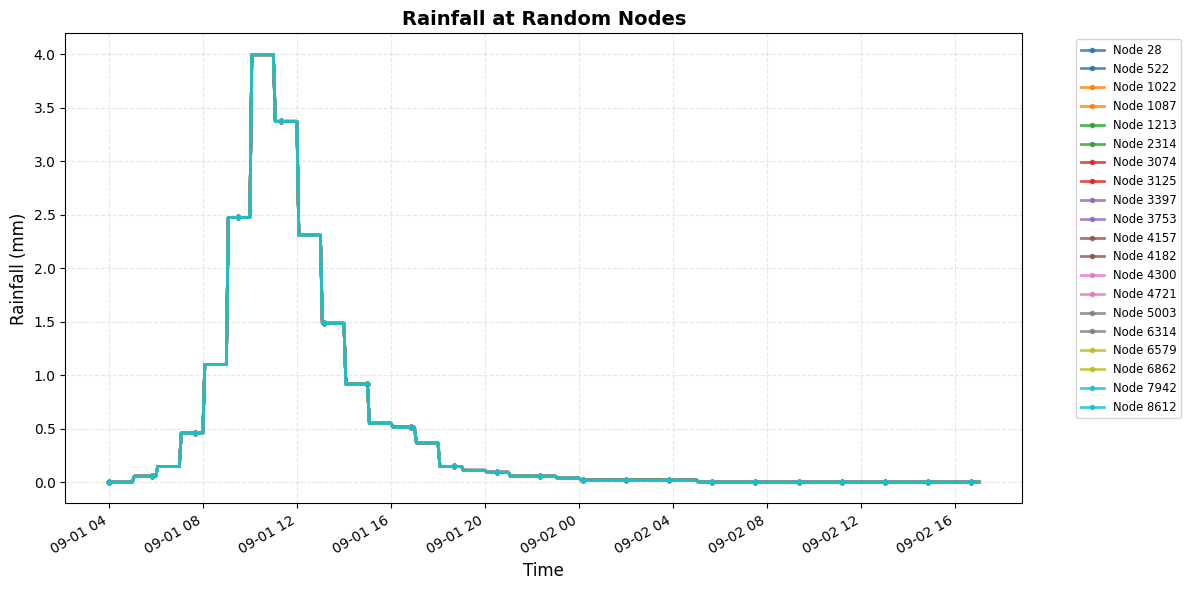


STATISTICS

node_28:
  Mean: 0.4944
  Std:  0.9714
  Min:  0.0000
  Max:  3.9967

node_522:
  Mean: 0.4944
  Std:  0.9714
  Min:  0.0000
  Max:  3.9967

node_1022:
  Mean: 0.4944
  Std:  0.9714
  Min:  0.0000
  Max:  3.9967

node_1087:
  Mean: 0.4944
  Std:  0.9714
  Min:  0.0000
  Max:  3.9967

node_1213:
  Mean: 0.4944
  Std:  0.9714
  Min:  0.0000
  Max:  3.9967

node_2314:
  Mean: 0.4944
  Std:  0.9714
  Min:  0.0000
  Max:  3.9967

node_3074:
  Mean: 0.4944
  Std:  0.9714
  Min:  0.0000
  Max:  3.9967

node_3125:
  Mean: 0.4944
  Std:  0.9714
  Min:  0.0000
  Max:  3.9967

node_3397:
  Mean: 0.4944
  Std:  0.9714
  Min:  0.0000
  Max:  3.9967

node_3753:
  Mean: 0.4944
  Std:  0.9714
  Min:  0.0000
  Max:  3.9967

node_4157:
  Mean: 0.4944
  Std:  0.9714
  Min:  0.0000
  Max:  3.9967

node_4182:
  Mean: 0.4944
  Std:  0.9714
  Min:  0.0000
  Max:  3.9967

node_4300:
  Mean: 0.4944
  Std:  0.9714
  Min:  0.0000
  Max:  3.9967

node_4721:
  Mean: 0.4944
  Std:  0.9714
  Min:  0.000

{'node_indices': array([  28,  522, 1022, 1087, 1213, 2314, 3074, 3125, 3397, 3753, 4157,
        4182, 4300, 4721, 5003, 6314, 6579, 6862, 7942, 8612]),
 'num_nodes_plotted': 20,
 'num_timesteps': 445,
 'feature_stats': {'node_28': {'mean': np.float64(0.49438195389308287),
   'std': np.float64(0.9713989159106587),
   'min': np.float64(0.0),
   'max': np.float64(3.996673583984375)},
  'node_522': {'mean': np.float64(0.49438195389308287),
   'std': np.float64(0.9713989159106587),
   'min': np.float64(0.0),
   'max': np.float64(3.996673583984375)},
  'node_1022': {'mean': np.float64(0.49438195389308287),
   'std': np.float64(0.9713989159106587),
   'min': np.float64(0.0),
   'max': np.float64(3.996673583984375)},
  'node_1087': {'mean': np.float64(0.49438195389308287),
   'std': np.float64(0.9713989159106587),
   'min': np.float64(0.0),
   'max': np.float64(3.996673583984375)},
  'node_1213': {'mean': np.float64(0.49438195389308287),
   'std': np.float64(0.9713989159106587),
   'min': np

In [ ]:
plot_nodes_from_csv(
    data_csv_path="/Users/jiayulim/Documents/GitHub/dual_flood_gnn/data/Model4/processed/features_csv/train/event_1/2d_nodes_dynamic_all.csv",
    timestamp_csv_path="/Users/jiayulim/Documents/GitHub/dual_flood_gnn/data/Model4/processed/features_csv/train/event_1/timesteps.csv",
    feature_column="rainfall",
    ylabel="Rainfall (mm)",
    title="Rainfall at Random Nodes",
    num_random_nodes=20,
    time_unit='datetime'
)

LOADING DATA FROM CSV FILES

Loading data from: /Users/jiayulim/Documents/GitHub/dual_flood_gnn/data/Model4/processed/features_csv/test/event_5/2d_nodes_dynamic_all.csv
  Rows: 3,962,725
  Columns: ['timestep', 'node_idx', 'rainfall', 'water_level', 'water_volume']

Loading timestamps from: /Users/jiayulim/Documents/GitHub/dual_flood_gnn/data/Model4/processed/features_csv/test/event_5/timesteps.csv
  Rows: 445
  Columns: ['timestep_idx', 'timestamp']
  Timestamp range: 2008-09-01 04:00:00 to 2008-09-02 17:00:00

Data Summary:
  Unique nodes: 8905
  Unique timesteps: 445
  Feature 'rainfall' range: [0.0000, 2.2992]

Plotting 20 nodes: [  63  528  959 1045 1569 2185 2231 2339 3640 3661 3850 3862 4395 5793
 6288 6833 6834 7015 8472 8698]


/var/folders/fd/qgmtjps95bzf3n9sz761k63h0000gn/T/ipykernel_22311/3157693029.py:194: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(colormap)


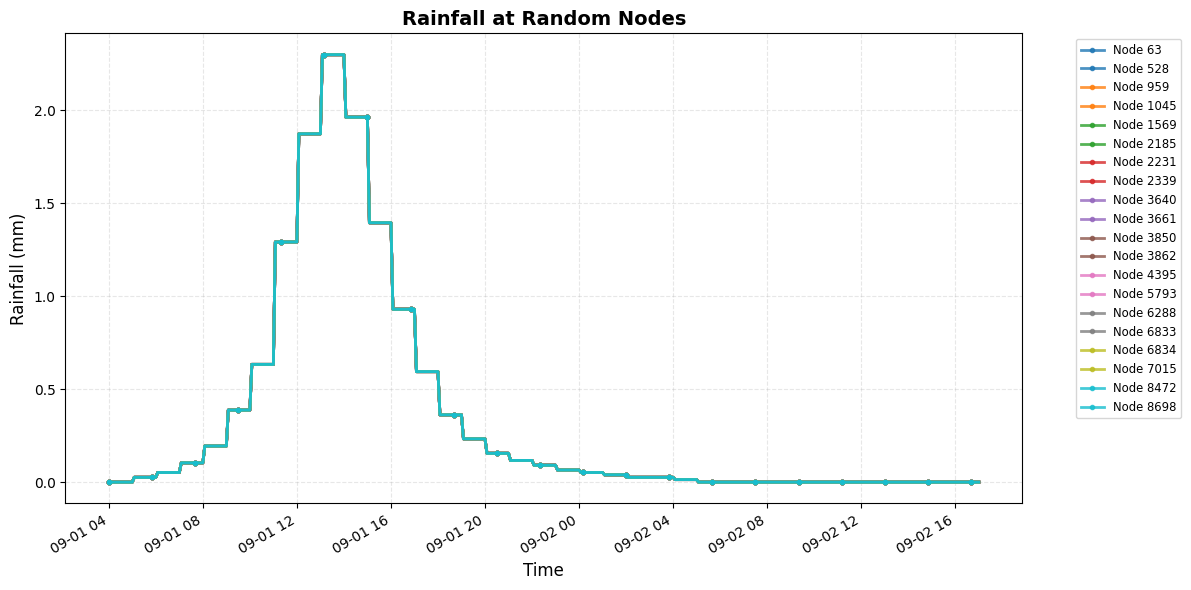


STATISTICS

node_63:
  Mean: 0.3484
  Std:  0.6106
  Min:  0.0000
  Max:  2.2992

node_528:
  Mean: 0.3484
  Std:  0.6106
  Min:  0.0000
  Max:  2.2992

node_959:
  Mean: 0.3484
  Std:  0.6106
  Min:  0.0000
  Max:  2.2992

node_1045:
  Mean: 0.3484
  Std:  0.6106
  Min:  0.0000
  Max:  2.2992

node_1569:
  Mean: 0.3484
  Std:  0.6106
  Min:  0.0000
  Max:  2.2992

node_2185:
  Mean: 0.3484
  Std:  0.6106
  Min:  0.0000
  Max:  2.2992

node_2231:
  Mean: 0.3484
  Std:  0.6106
  Min:  0.0000
  Max:  2.2992

node_2339:
  Mean: 0.3484
  Std:  0.6106
  Min:  0.0000
  Max:  2.2992

node_3640:
  Mean: 0.3484
  Std:  0.6106
  Min:  0.0000
  Max:  2.2992

node_3661:
  Mean: 0.3484
  Std:  0.6106
  Min:  0.0000
  Max:  2.2992

node_3850:
  Mean: 0.3484
  Std:  0.6106
  Min:  0.0000
  Max:  2.2992

node_3862:
  Mean: 0.3484
  Std:  0.6106
  Min:  0.0000
  Max:  2.2992

node_4395:
  Mean: 0.3484
  Std:  0.6106
  Min:  0.0000
  Max:  2.2992

node_5793:
  Mean: 0.3484
  Std:  0.6106
  Min:  0.0000

{'node_indices': array([  63,  528,  959, 1045, 1569, 2185, 2231, 2339, 3640, 3661, 3850,
        3862, 4395, 5793, 6288, 6833, 6834, 7015, 8472, 8698]),
 'num_nodes_plotted': 20,
 'num_timesteps': 445,
 'feature_stats': {'node_63': {'mean': np.float64(0.34840444500526685),
   'std': np.float64(0.6105779181689566),
   'min': np.float64(0.0),
   'max': np.float64(2.2991714477539062)},
  'node_528': {'mean': np.float64(0.34840444500526685),
   'std': np.float64(0.6105779181689566),
   'min': np.float64(0.0),
   'max': np.float64(2.2991714477539062)},
  'node_959': {'mean': np.float64(0.34840444500526685),
   'std': np.float64(0.6105779181689566),
   'min': np.float64(0.0),
   'max': np.float64(2.2991714477539062)},
  'node_1045': {'mean': np.float64(0.34840444500526685),
   'std': np.float64(0.6105779181689566),
   'min': np.float64(0.0),
   'max': np.float64(2.2991714477539062)},
  'node_1569': {'mean': np.float64(0.34840444500526685),
   'std': np.float64(0.6105779181689566),
   'min':

In [ ]:
plot_nodes_from_csv(
    data_csv_path="/Users/jiayulim/Documents/GitHub/dual_flood_gnn/data/Model4/processed/features_csv/test/event_5/2d_nodes_dynamic_all.csv",
    timestamp_csv_path="/Users/jiayulim/Documents/GitHub/dual_flood_gnn/data/Model4/processed/features_csv/test/event_5/timesteps.csv",
    feature_column="rainfall",
    ylabel="Rainfall (mm)",
    title="Rainfall at Random Nodes",
    num_random_nodes=20,
    time_unit='datetime'
)